# Class Imbalance Tutorial

This tutorial demonstrates how to handle **class imbalance** in binary classification tasks using **logistic regression**. We explore techniques such as **class weighting** and **SMOTE**, evaluate their impact, and compare results using metrics like **precision**, **recall**, **F1-score**, and **PR AUC**.

**Dataset:** [Credit Card Fraud Detection – Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)

 **Note:** The `creditcard.csv` file is too large to include directly in this repository.  
Please download the dataset from the link above and place the `creditcard.csv` file in the **same directory** as this notebook before running it.


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE

## Create necessary functions
Create the functions needed to produce accuracy results, classification reports and visualisations that showcase the difference between our 3 models

### Utility Functions
Here we define reusable functions for model evaluation, including classification reports, confusion matrices, and PR curves.

In [34]:
def plot_class_distribution(data, target_col='Class'):
    """Plot the percentage distribution of class labels with accessible, colorblind-safe styling."""

    
    sns.set(style="ticks")
    plt.figure(figsize=(8, 6))

    
    label_map = {0: 'Not Fraud', 1: 'Fraud'}
    data_copy = data.copy()
    data_copy[target_col] = data_copy[target_col].map(label_map)

    
    class_order = ['Not Fraud', 'Fraud']

  
    total = len(data_copy)
    class_counts = data_copy[target_col].value_counts()
    percentages = [round((class_counts[label] / total) * 100, 3) for label in class_order]

    # Use a colorblind-safe palette
    colors = sns.color_palette("colorblind", n_colors=2)


    ax = sns.countplot(
        data=data_copy,
        x=target_col,
        palette=colors,
        order=class_order
    )


    for p, perc in zip(ax.patches, percentages):
        height = p.get_height()
        ax.annotate(f'{perc:.3f}%', 
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=11, fontweight='bold')

  
    ax.set_title('Percentage of Transactions by Class', fontsize=16, fontweight='bold')
    ax.set_xlabel('Transaction Type', fontsize=13)
    ax.set_ylabel('Number of Transactions', fontsize=13)


    ax.grid(False)
    sns.despine()
    plt.tight_layout()
    plt.show()



In [35]:
def train_logistic_regression(X_train, y_train, X_test, class_weight=None):
    """
    Trains a logistic regression model and returns the trained model and predictions.
    """
    model = LogisticRegression(max_iter=1000, class_weight=class_weight)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, y_pred


In [36]:
# Train baseline logistic regression model
def train_logistic_regression_accuracy_only(X_train, y_train, X_test, y_test, class_weight=None):
    """Train a logistic regression model and print only overall accuracy."""
    
    model = LogisticRegression(max_iter=1000, class_weight=class_weight)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Logistic Regression (Class Weight = {class_weight}):")
    print(f"Overall Accuracy: {accuracy:.4f}")
    return model, y_pred

### Baseline Logistic Regression Model
We begin by training a logistic regression model without handling class imbalance. This serves as our baseline for comparison.

In [37]:
# Plot confusion matrix for Baseline Logistic Regression
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot a confusion matrix for model predictions."""
    
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=["Not Fraud", "Fraud"],
        cmap="Blues"
    )
    disp.ax_.set_title(title)
    plt.grid(False)
    plt.show()

In [38]:
def plot_confusion_matrices(model_outputs):
    """Plot confusion matrices for different models."""
    for title, (true, pred) in model_outputs.items():
        disp = ConfusionMatrixDisplay.from_predictions(
            true, pred, display_labels=["Not Fraud", "Fraud"]
        )
        disp.ax_.set_title(f'Confusion Matrix - {title}')
        plt.grid(False)
        plt.show()

In [39]:
def print_classification_metrics(y_true, y_pred):
    """Print precision, recall, and F1-score for each class."""
    report = classification_report(y_true, y_pred, target_names=["Not Fraud", "Fraud"])
    print("Classification Report (Per Class):")
    print(report)

In [40]:
def plot_pr_curve(model, X_test, y_test, title='Precision-Recall Curve'):
    """Plot the Precision-Recall curve for a binary classifier."""
    y_scores = model.predict_proba(X_test)[:, 1]  
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Precision-Recall Curve

This function helps us visualize the trade-off between precision and recall at different classification thresholds.

In [41]:
def run_class_weighted_model(X_train, y_train, X_test, y_test):
    """Train logistic regression with class weighting and evaluate performance."""

    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Classification Report – Class Weighted Model")
    print_classification_metrics(y_test, y_pred)
    
    plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix – Class Weighted Logistic Regression")
    plot_pr_curve(model, X_test, y_test, title='Precision-Recall Curve – Class Weighted Model')

    return model, y_pred

## Class-Weighted Logistic Regression ⚖️

We apply class weighting to give more importance to the minority class. This helps the model pay more attention to fraudulent transactions.

In [42]:
def run_smote_model(X_train, y_train, X_test, y_test):
    """Apply SMOTE, train logistic regression, and evaluate performance."""
    
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)

    print("Classification Report – SMOTE Model")
    print_classification_metrics(y_test, y_pred)

    plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix – Logistic Regression with SMOTE")
    plot_pr_curve(model, X_test, y_test, title="Precision-Recall Curve – SMOTE Model")

    return model, y_pred

## SMOTE Oversampling 
We use SMOTE to synthetically generate new samples of the minority class in the training data, aiming for better generalization.

## Load and Explore the Dataset 
We begin by loading the credit card fraud dataset and visualising the class distribution to highlight the severity of class imbalance.


### About the Dataset
This dataset contains credit card transactions from European cardholders over a two-day period in 2013. Only 0.172% of the transactions are fraudulent.

In [43]:
df = pd.read_csv("creditcard.csv")

/var/folders/_q/r7xlcst50v1b51ntr79cvyc80000gn/T/ipykernel_1139/434248044.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


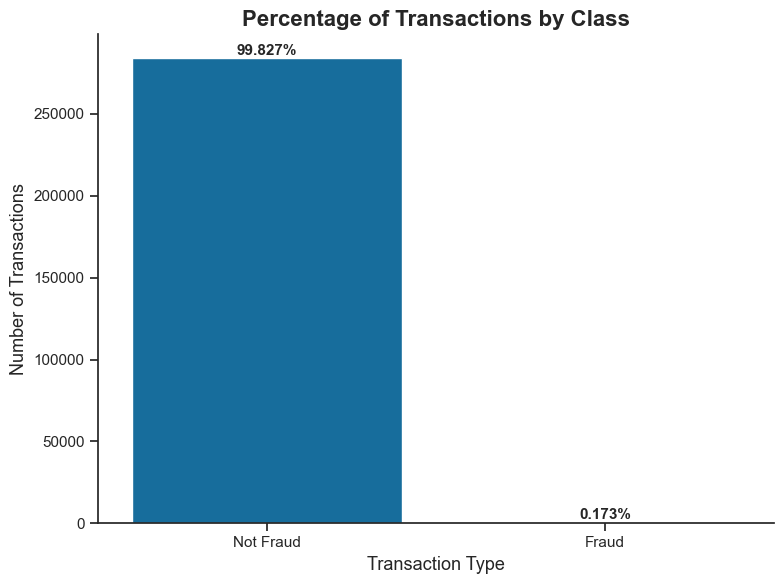

In [44]:
plot_class_distribution(df)

### Visualizing Class Distribution
Let's examine the distribution of fraud vs. non-fraud cases to highlight the class imbalance problem.

## Prepare the Data 🧹
We split the dataset into training and test sets using stratified sampling to preserve class proportions.


### Splitting the Dataset
We split the data into training and test sets using stratified sampling to preserve the proportion of fraud and non-fraud cases.

In [45]:

X = df.drop(['Time', 'Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

## Evaluation of Baseline Model
I used precision, recall, F1-score, and the precision-recall curve to understand how the model performs on this imbalanced dataset.
I trained a simple logistic regression model without applying any techniques to handle class imbalance. This will serve as our baseline for comparison.

In [46]:
baseline_model, y_pred_baseline = train_logistic_regression(
    X_train, y_train, X_test
)

In [47]:
baseline_model, y_pred_baseline = train_logistic_regression_accuracy_only(X_train, y_train, X_test, y_test)

Logistic Regression (Class Weight = None):
Overall Accuracy: 0.9992


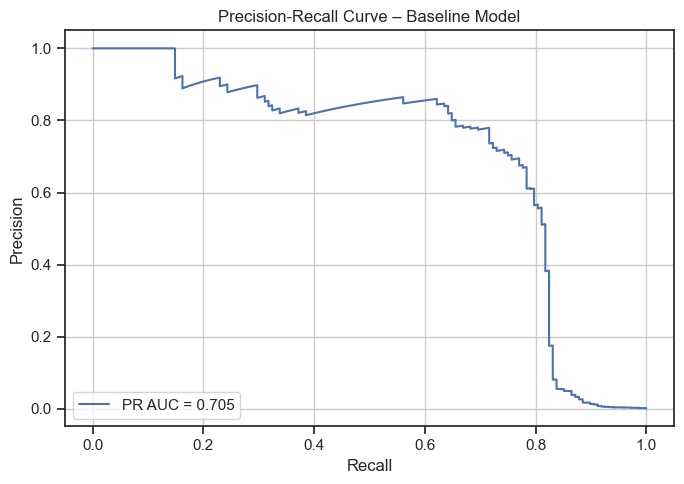

In [48]:
plot_pr_curve(baseline_model, X_test, y_test, title='Precision-Recall Curve – Baseline Model')

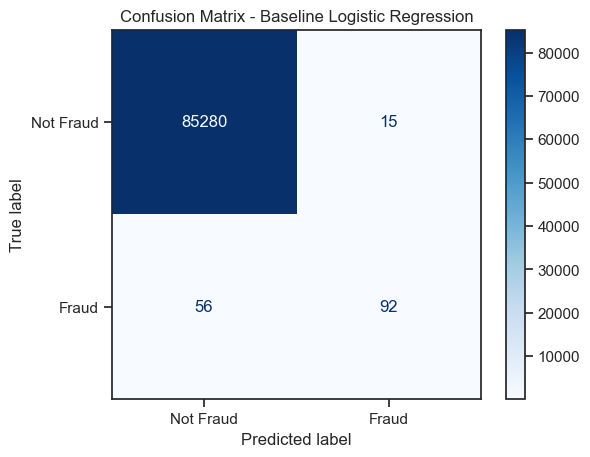

In [49]:
plot_confusion_matrix(y_test, y_pred_baseline, title="Confusion Matrix - Baseline Logistic Regression")

## Evaluation of Class-Weighted Model
Class weighting is a technique used to help machine learning models handle imbalanced datasets situations where one class (like fraud) is much less common than the other (like non-fraud). By default, most models treat every misclassification equally. But in an imbalanced dataset, that can cause the model to ignore the minority class, since it can achieve high accuracy just by always predicting the majority class.


Classification Report – Class Weighted Model
Classification Report (Per Class):
              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99     85295
       Fraud       0.06      0.87      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.92      0.55     85443
weighted avg       1.00      0.98      0.99     85443



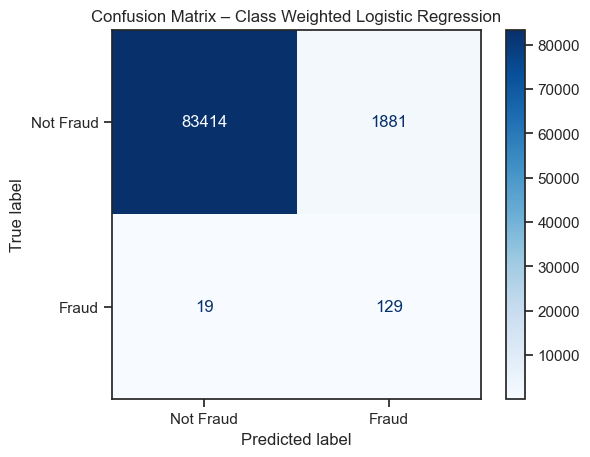

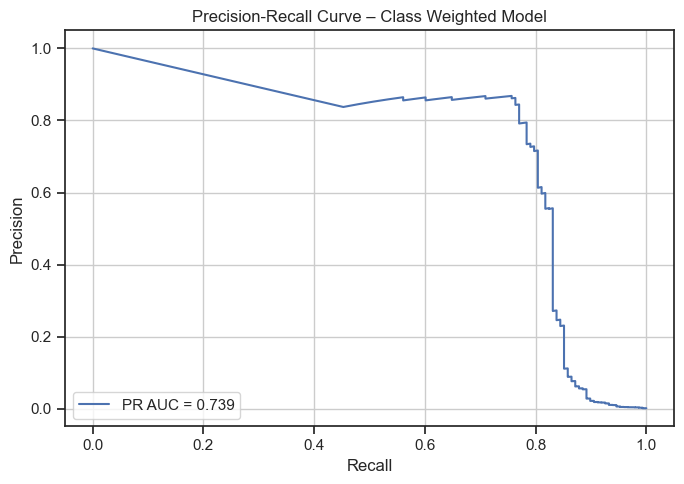

In [50]:
weighted_model, y_pred_weighted = run_class_weighted_model(X_train, y_train, X_test, y_test)

## SMOTE Oversampling Technique
SMOTE (Synthetic Minority Oversampling Technique) creates synthetic samples of the minority class to balance the dataset.

Classification Report – SMOTE Model
Classification Report (Per Class):
              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99     85295
       Fraud       0.08      0.86      0.15       148

    accuracy                           0.98     85443
   macro avg       0.54      0.92      0.57     85443
weighted avg       1.00      0.98      0.99     85443



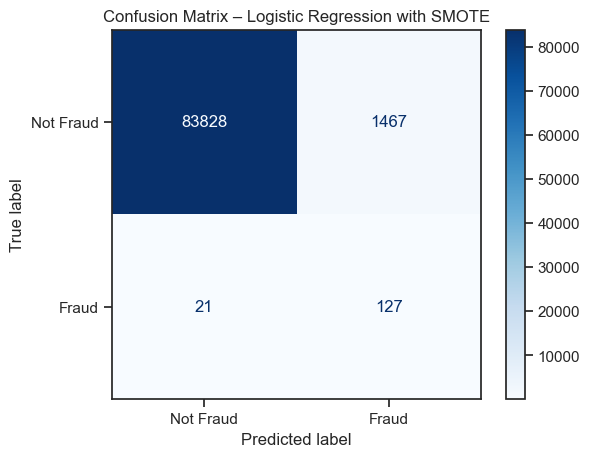

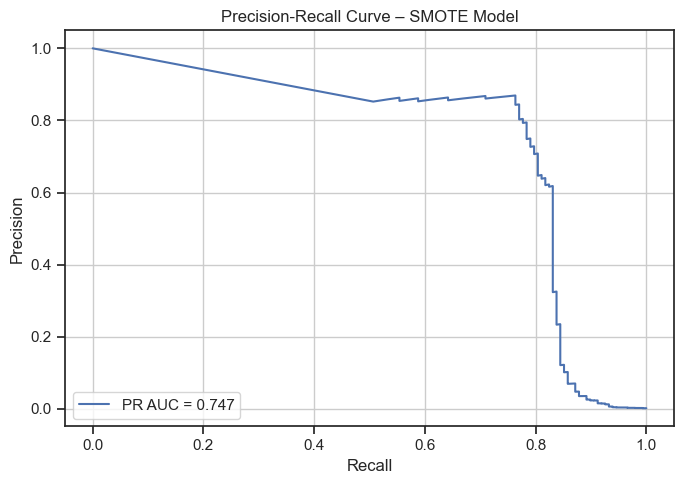

In [51]:
smote_model, y_pred_smote = run_smote_model(X_train, y_train, X_test, y_test)

## Conclusion
Among the methods explored, SMOTE provided the best balance between recall and precision. Choosing the right approach depends on your use case and the cost of false positives vs. false negatives.